## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Outline
* (1) Camera calibration
* (2) Distortion correction
* (3) Color and gradient threshold
* (4) Perspective transform
* (5) Line finding

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math

%matplotlib inline

## (1) Camera calibration

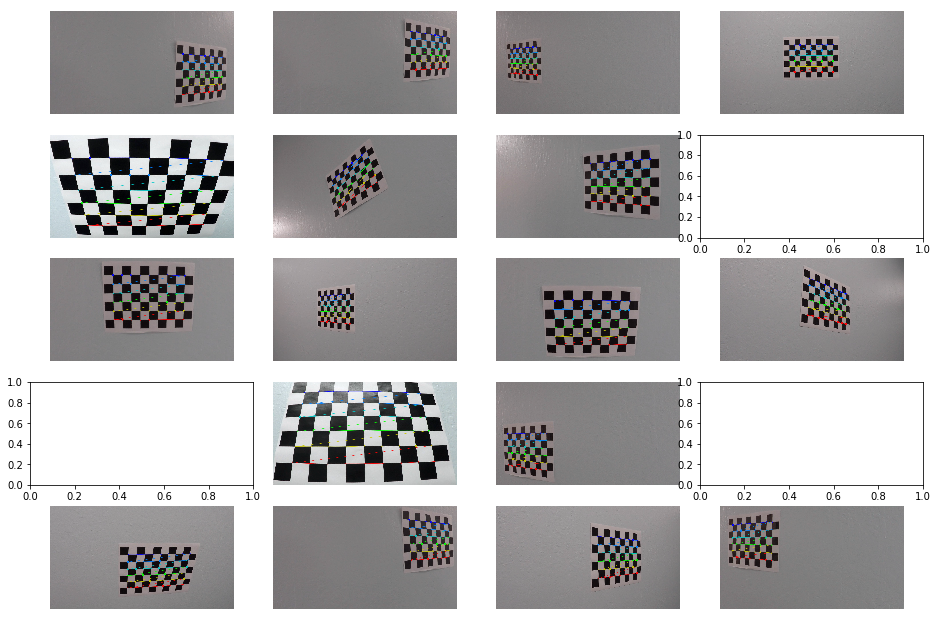

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)

## (2) Distortion correction

Text(0.5,1,'Undistorted Image')

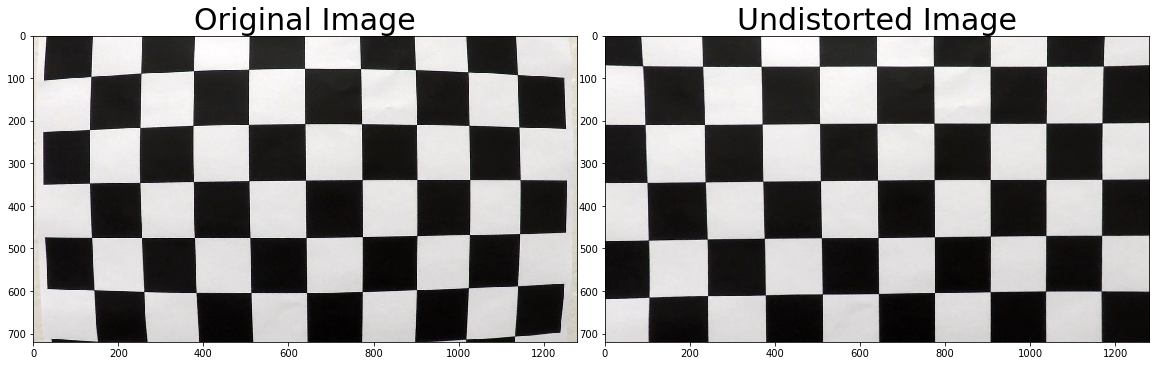

In [3]:
# Test undistortion on an image
img = mpimg.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


In [4]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

(-0.5, 1279.5, 719.5, -0.5)

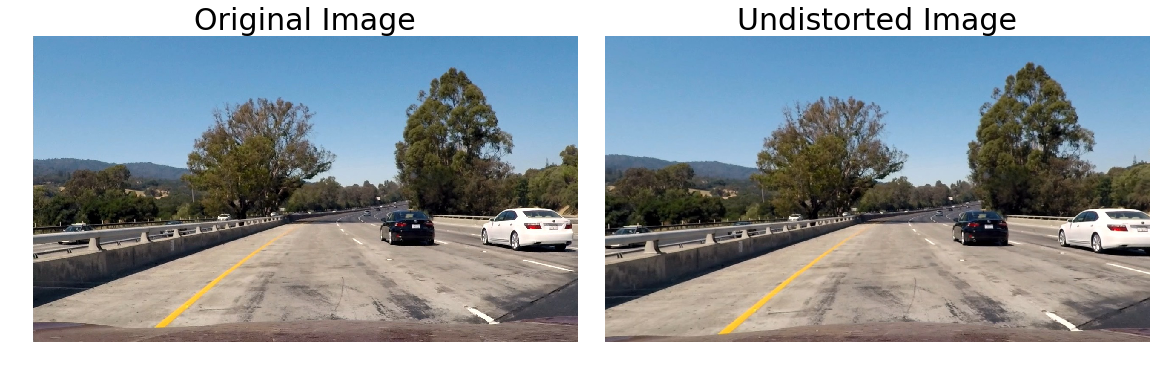

In [5]:
img_original = mpimg.imread('test_images/test1.jpg')
test = undistort(img_original)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img_original)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax2.imshow(test)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.axis('off')


In [6]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def Lane_Finding_pipeline(img, low_threshold, high_threshold, kernel_size, vertices, rho, theta, threshold, min_line_len, max_line_gap, showflag):
    # 1st step: RGB to Gray
    gray = grayscale(img)
    
    # 2nd step: Filtering and Canny
    gray_blur = gaussian_blur(gray, kernel_size)
    gray_canny = canny(gray_blur, low_threshold, high_threshold)
    
    # 3rd step: ROI 
    masked_image = region_of_interest(gray_canny, vertices)
    
    # 4th step: Hough
    line_img, lines = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    
    # 5th step: Devide lines into right and lift lines and calculate average lines by liner regression
    x_R=[]
    x_L=[]
    y_R=[]
    y_L=[]
    s = img.shape
    for line in lines:
        for x1, y1, x2, y2 in line:
            if (y2-y1)/(x2-x1)>0: # Right line
                if x1 > s[1]/2 and x2 > s[1]/2: # Right line is located in half-right
                    x_R.append(x1)
                    x_R.append(x2)
                    y_R.append(y1)
                    y_R.append(y2)
            elif (y2-y1)/(x2-x1)<0: # Left line
                if x1 < s[1]/2 and x2 < s[1]/2: # Left line is located in half-left
                    x_L.append(x1)
                    x_L.append(x2)
                    y_L.append(y1)
                    y_L.append(y2)
    
    # Liner-Regression for calculating each average line
    a_r, b_r = np.polyfit(np.array(x_R), np.array(y_R), 1) # right average line
    a_l, b_l = np.polyfit(np.array(x_L), np.array(y_L), 1) # left average line
    y_start = int(s[0]*2/3)
    y_end = int(s[0])
    x_r_start = int((y_start - b_r) / a_r)
    x_r_end = int((y_end - b_r) / a_r)
    x_l_start = int((y_start - b_l) / a_l)
    x_l_end = int((y_end - b_l) / a_l)
    
    ave_line_r = np.array([[[x_r_start, y_start, x_r_end, y_end]]])
    ave_line_l = np.array([[[x_l_start, y_start, x_l_end, y_end]]])
    
    # drawing the lines
    draw_lines(line_img, ave_line_r, color=[255, 0, 0], thickness=2) # draw the right average line
    draw_lines(line_img, ave_line_l, color=[255, 0, 0], thickness=2) # draw the left average line
    im = weighted_img(line_img, img)
    area = np.array([[x_r_start, y_start],[x_r_end, y_end],[x_l_end, y_end],[x_l_start, y_start]])

    # cv2.fillConvexPoly(im, area, (100,255,100)) # If you want to show road area, use it.
    
    if showflag: 
        plt.imshow(im)
        plt.plot(x_R, y_R)
        plt.plot(x_L, y_L)
        plt.show()
    
    return im, lines

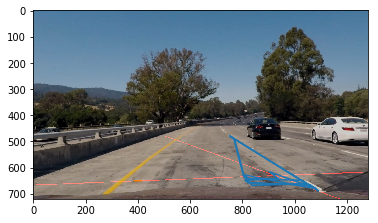

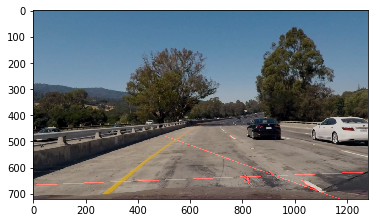

In [7]:
img_original = mpimg.imread('test_images/test1.jpg')
img = undistort(img_original)
imshape = img.shape

kernel_size = 3 # blur params
low_threshold = 180 # canny params
high_threshold = 250 # canny params

# vertices = np.array([[(0,imshape[0]),(0, imshape[0]/2), (imshape[1], imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)  # ROI
# vertices = np.array([[(150,imshape[0]),(150, imshape[0]/2), (850, imshape[0]/2), (850,imshape[0])]], dtype=np.int32)  # ROI
vertices = np.array([[(180,690), (570,460), (730,460), (1110,690)]], dtype=np.int32)

rho = 2  # hough params
theta = np.pi/180  # hough params
threshold = 15  # hough params
min_line_len = 15  # hough params
max_line_gap = 20  # hough params

line_img, lines= Lane_Finding_pipeline(img, low_threshold, high_threshold, kernel_size, vertices, rho, theta, threshold, min_line_len, max_line_gap, True)
plt.imshow(line_img)

## (3) Color and gradient threshold

(-0.5, 1279.5, 719.5, -0.5)

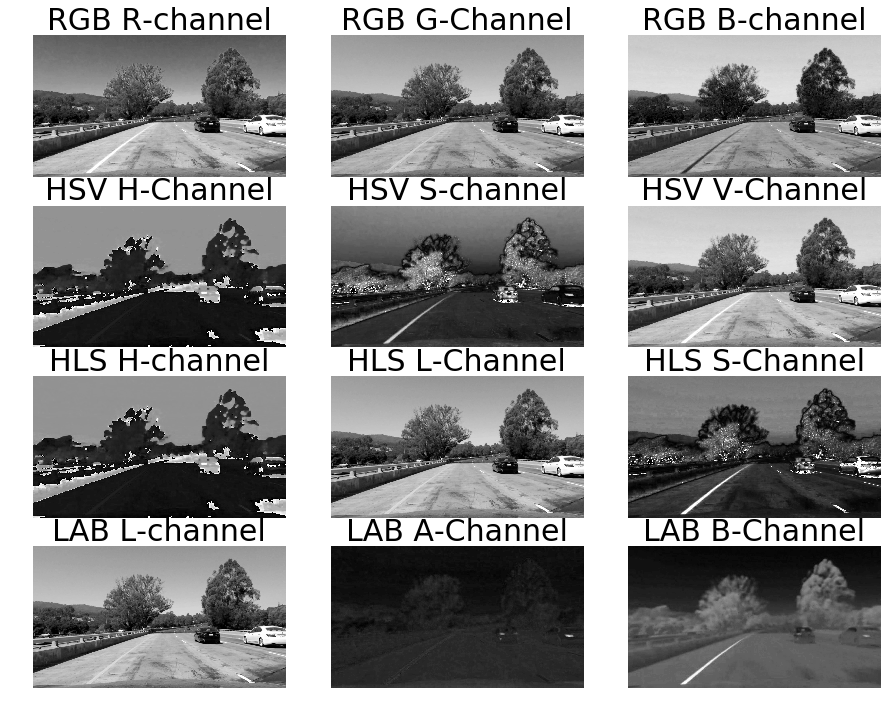

In [8]:
# (3) Color and gradient threshold
rgb = test
R = rgb[:,:,0]
G = rgb[:,:,1]
B = rgb[:,:,2]
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
H = hsv[:,:,0]
S = hsv[:,:,1]
V = hsv[:,:,2]
hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
HH = hls[:,:,0]
L = hls[:,:,1]
SS = hls[:,:,2]
lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
L = lab[:,:,0]
A = lab[:,:,1]
BB = lab[:,:,2]

fig, axs = plt.subplots(4,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].imshow(R, cmap='gray')
axs[0].set_title('RGB R-channel', fontsize=30)
axs[0].axis('off')
axs[1].imshow(G, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=30)
axs[1].axis('off')
axs[2].imshow(B, cmap='gray')
axs[2].set_title('RGB B-channel', fontsize=30)
axs[2].axis('off')
axs[3].imshow(H, cmap='gray')
axs[3].set_title('HSV H-Channel', fontsize=30)
axs[3].axis('off')
axs[4].imshow(S, cmap='gray')
axs[4].set_title('HSV S-channel', fontsize=30)
axs[4].axis('off')
axs[5].imshow(V, cmap='gray')
axs[5].set_title('HSV V-Channel', fontsize=30)
axs[5].axis('off')
axs[6].imshow(HH, cmap='gray')
axs[6].set_title('HLS H-channel', fontsize=30)
axs[6].axis('off')
axs[7].imshow(L, cmap='gray')
axs[7].set_title('HLS L-Channel', fontsize=30)
axs[7].axis('off')
axs[8].imshow(SS, cmap='gray')
axs[8].set_title('HLS S-Channel', fontsize=30)
axs[8].axis('off')
axs[9].imshow(L, cmap='gray')
axs[9].set_title('LAB L-channel', fontsize=30)
axs[9].axis('off')
axs[10].imshow(A, cmap='gray')
axs[10].set_title('LAB A-Channel', fontsize=30)
axs[10].axis('off')
axs[11].imshow(BB, cmap='gray')
axs[11].set_title('LAB B-Channel', fontsize=30)
axs[11].axis('off')

In [9]:
# functions
# sobel
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sbinary) # Remove this line
    return binary_output

# sobel_mag
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    thresh_min = mag_thresh[0]
    thresh_max =mag_thresh[1]
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sbinary) # Remove this line
    return binary_output

# sobel_dir
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grd = np.arctan2(abs_y, abs_x)
    # 5) Create a binary mask where direction thresholds are met
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sbinary = np.zeros_like(grd)
    sbinary[(grd >= thresh_min) & (grd <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sbinary) # Remove this line
    return binary_output

# HSV - H
def H_threshold(img, thresh=(0, 255)):
    # 1) Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H = H*(255/np.max(H))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(H)
    binary_output[(H > thresh[0]) & (H <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# HSV - S
def S_threshold(img, thresh=(0, 255)):
    # 1) Convert to HSV
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    S = S*(255/np.max(S))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# LAB- B
def B_threshold(img, thresh=(0, 255)):
    # 1) Convert to HSV
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    B = lab[:,:,2]
    B = B*(255/np.max(B))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(B)
    binary_output[(B > thresh[0]) & (B <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

(-0.5, 1279.5, 719.5, -0.5)

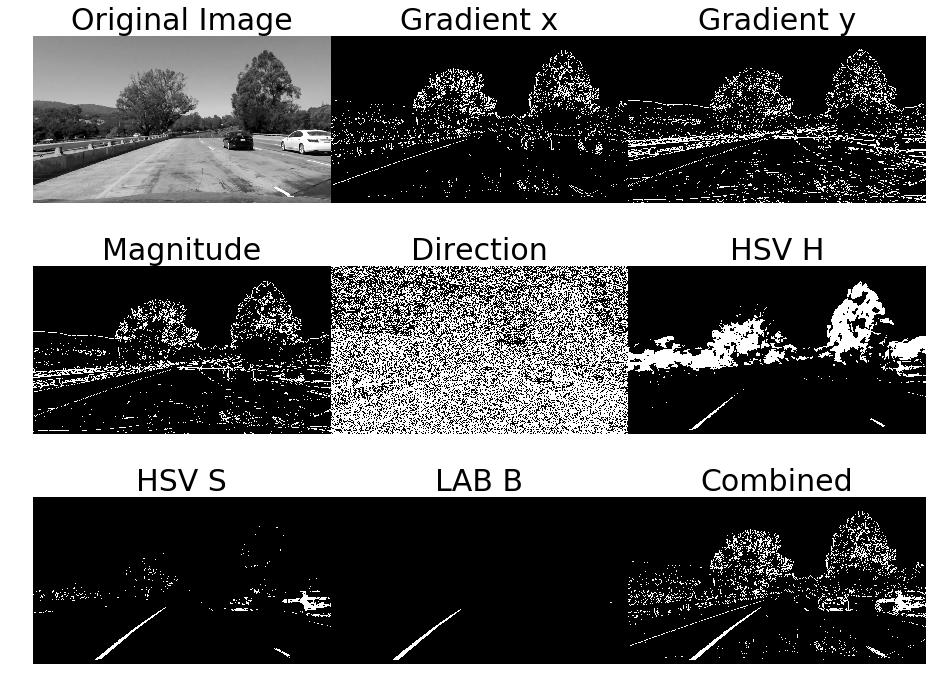

In [10]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
image = undistort(mpimg.imread('test_images/test1.jpg'))

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20,100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.5, 1.5))
H_binary = H_threshold(image, thresh=(30, 100))
S_binary = S_threshold(image, thresh=(170, 255))
B_binary = B_threshold(image, thresh=(200, 255))
combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((H_binary == 1) | (S_binary == 1))] = 1
# combined[(S_binary == 1)] = 1
# combined[((H_binary == 1) | (S_binary == 1))] = 1
# combined[((gradx == 1) | (S_binary == 1))] = 1
combined[((S_binary == 1) | (B_binary == 1) | (gradx == 1))] = 1

fig, axs = plt.subplots(3,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cmap='gray')
axs[0].set_title('Original Image', fontsize=30)
axs[0].axis('off')
axs[1].imshow(gradx, cmap='gray')
axs[1].set_title('Gradient x', fontsize=30)
axs[1].axis('off')
axs[2].imshow(grady, cmap='gray')
axs[2].set_title('Gradient y', fontsize=30)
axs[2].axis('off')
axs[3].imshow(mag_binary, cmap='gray')
axs[3].set_title('Magnitude', fontsize=30)
axs[3].axis('off')
axs[4].imshow(dir_binary, cmap='gray')
axs[4].set_title('Direction', fontsize=30)
axs[4].axis('off')
axs[5].imshow(H_binary, cmap='gray')
axs[5].set_title('HSV H', fontsize=30)
axs[5].axis('off')
axs[6].imshow(S_binary, cmap='gray')
axs[6].set_title('HSV S', fontsize=30)
axs[6].axis('off')
axs[7].imshow(B_binary, cmap='gray')
axs[7].set_title('LAB B', fontsize=30)
axs[7].axis('off')
axs[8].imshow(combined, cmap='gray')
axs[8].set_title('Combined', fontsize=30)
axs[8].axis('off')

In [11]:
def filt_im(image,ksize):
    # Apply each of the thresholding functions
    image = undistort(image)
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20,100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.5, 1.5))
    H_binary = H_threshold(image, thresh=(30, 100))
    S_binary = S_threshold(image, thresh=(170, 255))
    B_binary = B_threshold(image, thresh=(200, 255))
    combined = np.zeros_like(dir_binary)
    # combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((H_binary == 1) | (S_binary == 1))] = 1
    # combined[(S_binary == 1)] = 1
    # combined[((H_binary == 1) | (S_binary == 1))] = 1
    # combined[((gradx == 1) | (S_binary == 1))] = 1
    combined[((S_binary == 1) | (B_binary == 1) | (gradx == 1))] = 1
    return combined

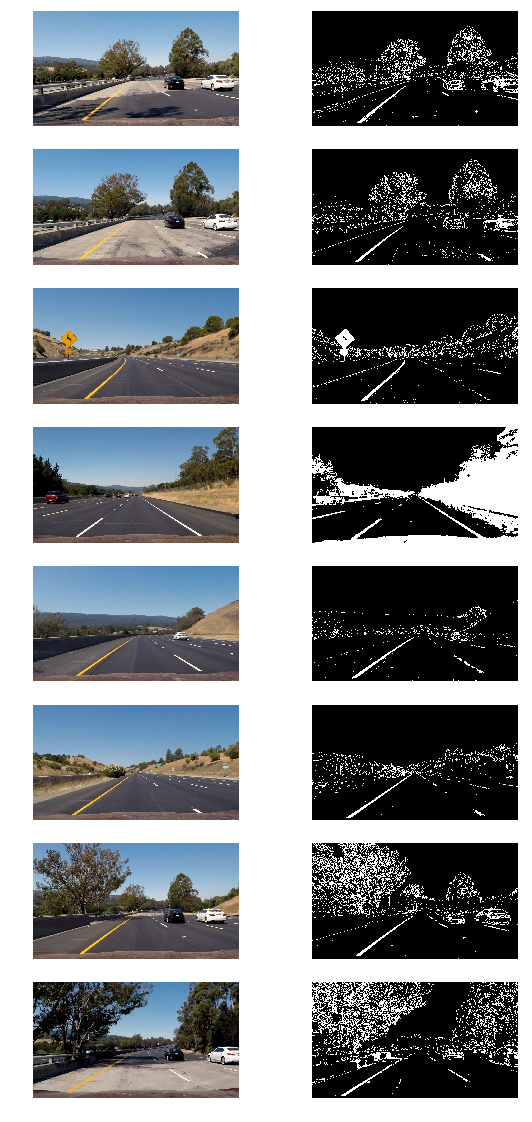

In [12]:
# Make a list of example images
images = glob.glob('test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
ksize = 3
for image in images:
    img = mpimg.imread(image)
    img_bin = filt_im(img, ksize)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

## (4) Perspective transform

In [13]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

Text(0.5,1,'Unwarped Image')

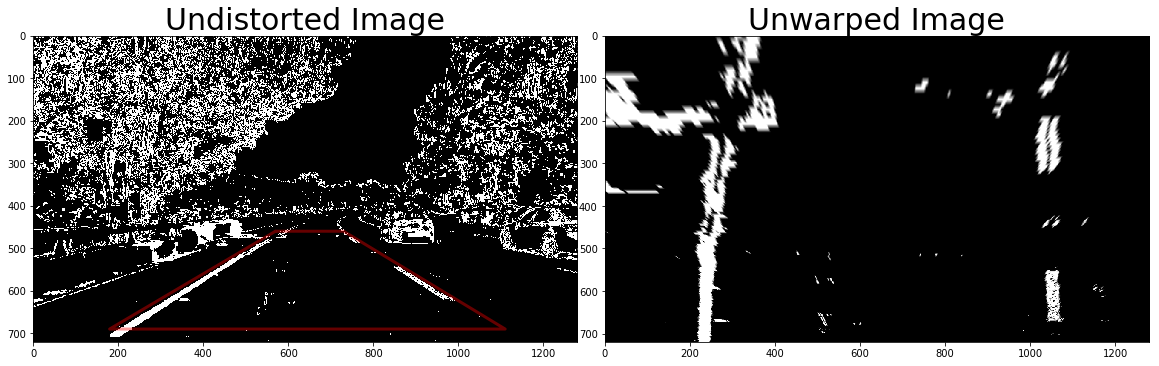

In [14]:
h,w = img_bin.shape[:2]

# define source and destination points for transform
src = np.float32([(570,460),
                  (730,460), 
                  (180,690), 
                  (1110,690)])
offset = 200
dst = np.float32([(offset,0),
                  (w-offset,0),
                  (offset,h),
                  (w-offset,h)])

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
img_unwarp, M, Minv = unwarp(img_bin, src, dst)
ax1.imshow(img_bin,cmap='gray')
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(img_unwarp,cmap='gray')
ax2.set_title('Unwarped Image', fontsize=30)

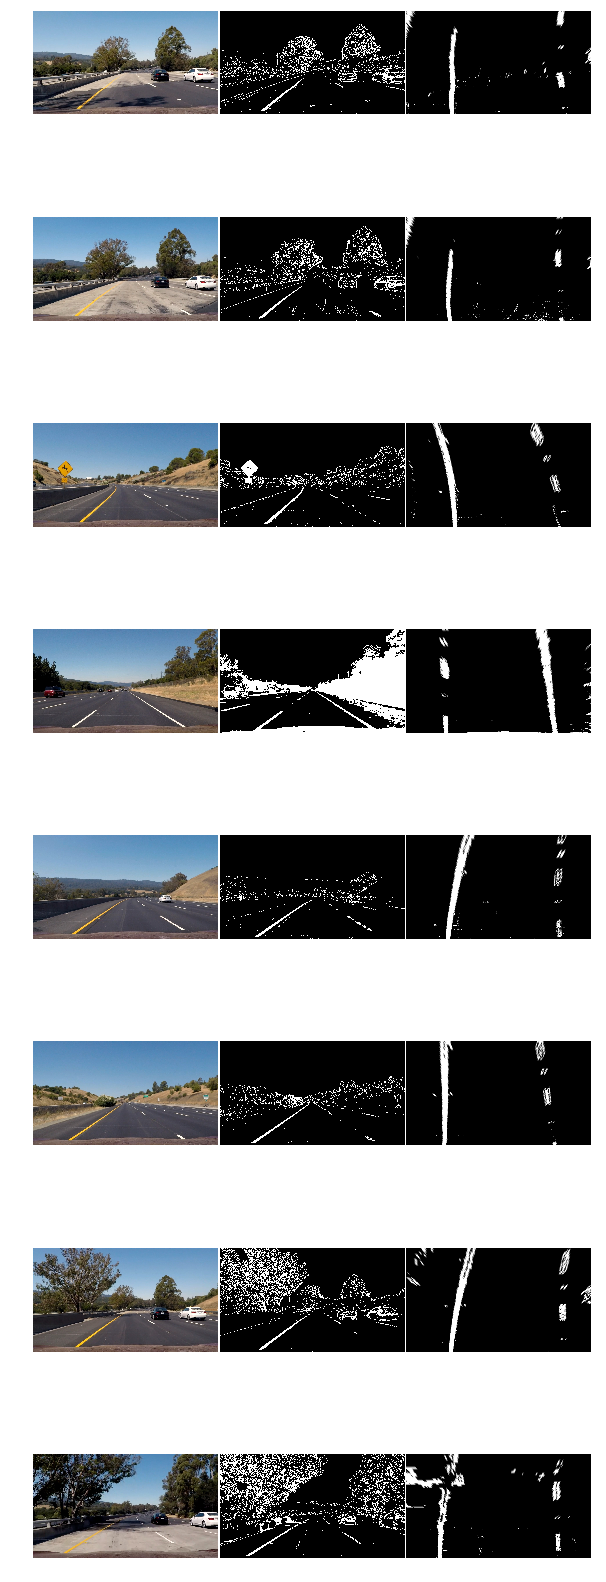

In [15]:
# Make a list of example images
images = glob.glob('test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(10, 30))
fig.subplots_adjust(hspace = .1, wspace=.01)
axs = axs.ravel()
                  
i = 0
ksize = 3
for image in images:
    img = mpimg.imread(image)
    img_bin = filt_im(img, ksize)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
    img_unwarp, M, Minv = unwarp(img_bin, src, dst)
    axs[i].imshow(img_unwarp, cmap='gray')
    axs[i].axis('off')
    i += 1

## (5) Line finding

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([0,0,0], dtype='float') 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None  

In [17]:
l_line = Line()
r_line = Line()

In [24]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img = out_img.astype(np.uint8)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    if leftx.size != 0:
        left_fit = np.polyfit(lefty, leftx ,2)
    else:
        leftx = l_line.allx
        lefty= l_line.ally
        left_fit = l_line.current_fit
        
    if rightx.size != 0:
        right_fit = np.polyfit(righty, rightx ,2)
    else :
        rightx = r_line.allx
        righty= r_line.ally
        right_fit = r_line.current_fit

    # Generate x and y values for plotting
    # ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        l_line.detected = True
        r_line.detected = True
        l_line.allx = leftx
        l_line.ally = lefty
        r_line.allx = rightx
        r_line.ally = righty
        l_line.current_fit = left_fit
        r_line.current_fit = right_fit
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_fit, right_fit, left_fitx, right_fitx

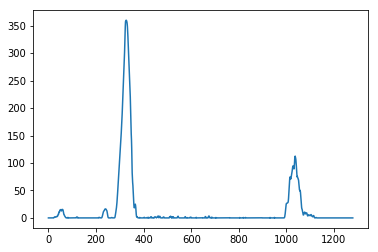

In [25]:
# Load our image
img = mpimg.imread('test_images/test2.jpg')
img_bin = filt_im(img, ksize)
img_unwarp, M, Minv  = unwarp(img_bin, src, dst)
ploty = np.linspace(0, img_unwarp.shape[0]-1, img_unwarp.shape[0])
histogram = np.sum(img_unwarp[img_unwarp.shape[0]//2:,:], axis=0)
plt.plot(histogram)
leftx, lefty, rightx, righty, out_img = find_lane_pixels(img_unwarp)
out_img, left_fit, right_fit, left_fitx, right_fitx  = fit_polynomial(img_unwarp)


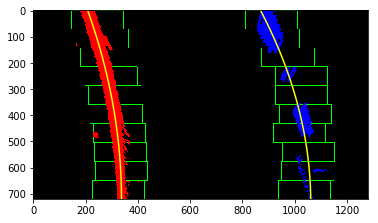

In [26]:
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

In [27]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    if leftx.size != 0:
            left_fit = np.polyfit(lefty, leftx ,2)
    else:
        leftx = l_line.allx
        lefty= l_line.ally
        left_fit = l_line.current_fit
        
    if rightx.size != 0:
        right_fit = np.polyfit(righty, rightx ,2)
    else:
        rightx = r_line.allx
        righty= r_line.ally
        right_fit = r_line.current_fit
        
    # Generate x and y values for plotting
    # ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_fit, right_fit

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 150

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    # Fit new polynomials
    if leftx.size != 0 or rightx.size != 0:
        left_fitx2, right_fitx2, left_fit2, right_fit2 = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        l_line.diffs = l_line.current_fit - left_fit2
        r_line.diffs = r_line.current_fit - right_fit2

        if np.sum(np.abs(l_line.diffs)) < 1000  or np.sum(np.array(r_line.diffs)) < 1000 :    
            l_line.allx = leftx
            l_line.ally = lefty
            r_line.allx = rightx
            r_line.ally = righty
            l_line.current_fit = left_fit2
            r_line.current_fit = right_fit2
        else :
            leftx = l_line.allx
            lefty= l_line.ally
            rightx = r_line.allx
            righty= r_line.ally
            left_fit2 = l_line.current_fit
            right_fit2 = r_line.current_fit
            l_line.diffs = l_line.current_fit - left_fit2
            r_line.diffs = r_line.current_fit - right_fit2
            left_fitx2 = left_fit2[0] * ploty**2 + left_fit2[1] * ploty + left_fit2[2]
            right_fitx2 = right_fit2[0] * ploty**2 + right_fit2[1] * ploty + right_fit2[2]  
    else :
        leftx = l_line.allx
        lefty= l_line.ally
        rightx = r_line.allx
        righty= r_line.ally
        left_fit2 = l_line.current_fit
        right_fit2 = r_line.current_fit
        l_line.diffs = l_line.current_fit - left_fit2
        r_line.diffs = r_line.current_fit - right_fit2
        left_fitx2 = left_fit2[0] * ploty**2 + left_fit2[1] * ploty + left_fit2[2]
        right_fitx2 = right_fit2[0] * ploty**2 + right_fit2[1] * ploty + right_fit2[2]
        l_line.detected = False
        r_line.detected = False
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx2-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx2+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx2-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx2+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fit2, right_fit2, left_fitx2, right_fitx2

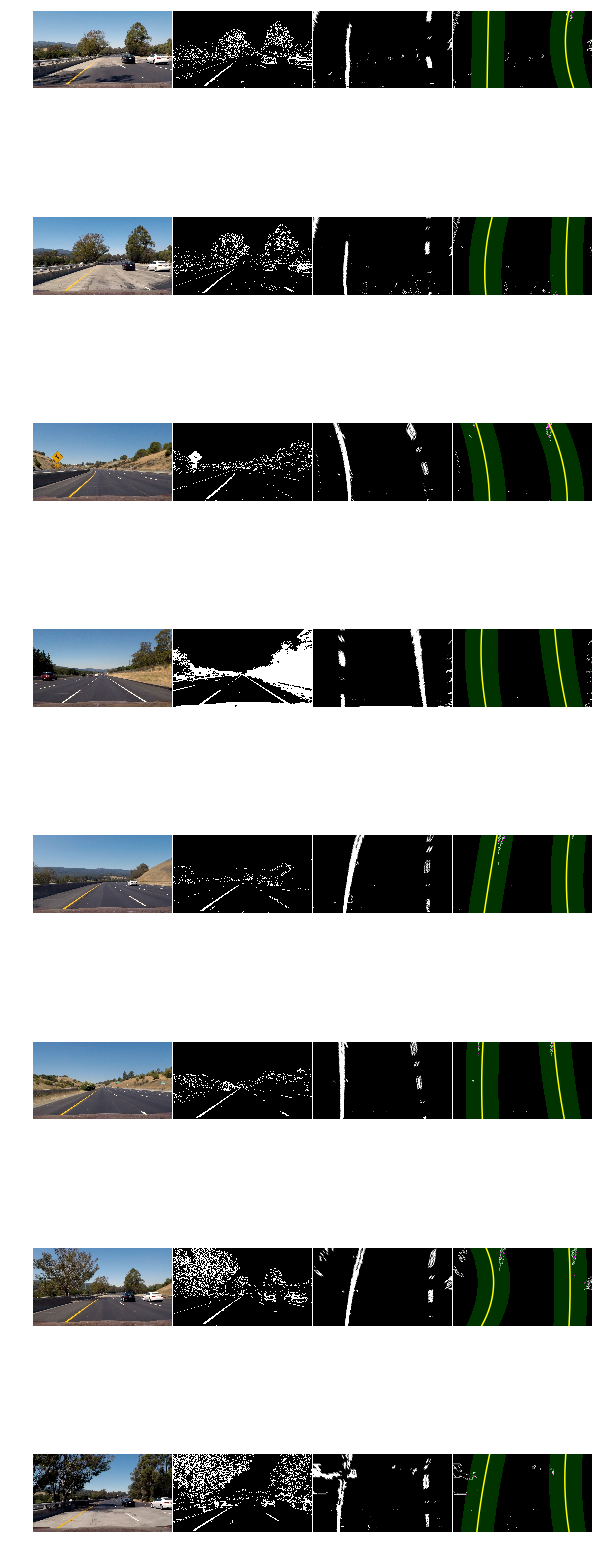

In [28]:
# Make a list of example images
images = glob.glob('test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),4, figsize=(10, 30))
fig.subplots_adjust(hspace = .1, wspace=.01)
axs = axs.ravel()
                  
i = 0
ksize = 3
for image in images:
    img = mpimg.imread(image)
    img_bin = filt_im(img, ksize)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
    img_unwarp, M, Minv = unwarp(img_bin, src, dst)
    axs[i].imshow(img_unwarp, cmap='gray')
    axs[i].axis('off')
    i += 1
    out_img, left_fit, right_fit, left_fitx, right_fitx  = search_around_poly(img_unwarp)
    axs[i].imshow(out_img)
    axs[i].plot(left_fitx, ploty, color='yellow')
    axs[i].plot(right_fitx, ploty, color='yellow')
    axs[i].axis('off')
    i += 1


(-0.5, 1279.5, 719.5, -0.5)

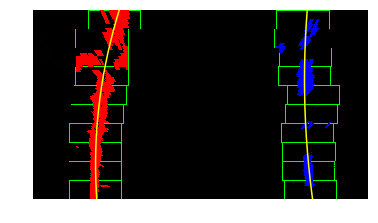

In [29]:
out_img, left_fit, right_fit, left_fitx, right_fitx  = fit_polynomial(img_unwarp)

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)
plt.axis('off')

In [30]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    A = left_fit[0]
    B=  left_fit[1]
    left_curverad = ((1+(2*A*y_eval+B)**2)**(3/2))/np.absolute(2*A)  ## Implement the calculation of the left line here
    
    A = right_fit[0]
    B=  right_fit[1]
    right_curverad = ((1+(2*A*y_eval+B)**2)**(3/2))/np.absolute(2*A)  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)

print(left_curverad, right_curverad)

1933.85857021 3473.03787103


In [31]:
def measure_curvature_real(img, ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    l_line.radius_of_curvature = left_curverad
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    r_line.radius_of_curvature = right_curverad
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    car_position = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*h**2 + left_fit_cr[1]*h + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*h**2 + right_fit_cr[1]*h + right_fit_cr[2]
    l_line.line_base_pos = np.absolute(l_fit_x_int - car_position)* xm_per_pix
    r_line.line_base_pos = np.absolute(r_fit_x_int - car_position)* xm_per_pix
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_err = (car_position - lane_center_position) * xm_per_pix

    return left_curverad, right_curverad, center_err
    

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, center_err  = measure_curvature_real(img_bin, ploty, left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm', center_err, 'm')

2167.93056511 m 3405.07031202 m -0.0817779951182 m


In [ ]:
img = mpimg.imread('test_images/test2.jpg')

def pipeline(img):
    undist = undistort(img)
    img_bin = filt_im(img, ksize)
    img_unwarp, M, Minv  = unwarp(img_bin, src, dst)
    out_img, left_fit, right_fit, left_fitx, right_fitx  = fit_polynomial(img_unwarp)
    #result, left_fit2, right_fit2, left_fitx2, right_fitx2 = search_around_poly(img_unwarp)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_unwarp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # Curveture
    left_curverad2, right_curverad2, center_err = measure_curvature_real(img_bin, ploty, left_fit, right_fit)
    curv_rad = (left_curverad2 + right_curverad2)/2

    texted_img = drow_text(result, curv_rad, center_err, np.sum(np.abs(l_line.diffs)), np.sum(np.abs(r_line.diffs)))
    
    size = (int(result.shape[1]/3), int(result.shape[0]/3))
    cliped_img = add_clip_image(size[0]*2-30, 30, result, cv2.resize(out_img, size))

    return cliped_img

def drow_text(result, curv_rad, center_err, left_dif, right_dif):
    h = result.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(result, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_err > 0:
        direction = 'right'
    elif center_err < 0:
        direction = 'left'
    abs_center_err = abs(center_err)
    text = '{:04.3f}'.format(abs_center_err) + 'm ' + direction + ' of center'
    cv2.putText(result, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    text = 'Line Diff (sum of coefficient of second-order-regression)'
    cv2.putText(result, text, (40,170), int(font/2), 1.5, (200,255,155), 2, cv2.LINE_AA)
    text = 'Left: ' + '{:04.3f}'.format(left_dif) + '      Right: ' + '{:04.3f}'.format(right_dif) 
    cv2.putText(result, text, (40,220), int(font/2), 1.5, (200,255,155), 2, cv2.LINE_AA)
    return result

def add_clip_image(x, y, back, fore):
    h, w, _ = fore.shape
    back[y:y+h, x:x+w] = fore
    cliped_img = back
    return cliped_img

cliped_img = pipeline(img)
plt.imshow(cliped_img)
plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

In [ ]:
# Make a list of example images
images = glob.glob('test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),5, figsize=(10, 30))
fig.subplots_adjust(hspace = .1, wspace=.01)
axs = axs.ravel()
                  
i = 0
ksize = 3
for image in images:
    img = mpimg.imread(image)
    img_bin = filt_im(img, ksize)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
    img_unwarp, M, Minv = unwarp(img_bin, src, dst)
    axs[i].imshow(img_unwarp, cmap='gray')
    axs[i].axis('off')
    i += 1
    out_img, left_fit, right_fit, left_fitx, right_fitx  = fit_polynomial(img_unwarp)
    axs[i].imshow(out_img)
    axs[i].plot(left_fitx, ploty, color='yellow')
    axs[i].plot(right_fitx, ploty, color='yellow')
    axs[i].axis('off')
    i += 1
    result = pipeline(img)
    axs[i].imshow(result)
    axs[i].axis('off')
    i += 1
    

In [ ]:
def pipeline4video(img):
    undist = undistort(img)
    img_bin = filt_im(img, ksize)
    img_unwarp, M, Minv  = unwarp(img_bin, src, dst)
    
    if not l_line.detected or not r_line.detected:
        out_img, left_fit, right_fit, left_fitx, right_fitx  = fit_polynomial(img_unwarp)
    else:
        out_img, left_fit, right_fit, left_fitx, right_fitx = search_around_poly(img_unwarp)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_unwarp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # Curveture
    left_curverad2, right_curverad2, center_err = measure_curvature_real(img_bin, ploty, left_fit, right_fit)
    curv_rad = (left_curverad2 + right_curverad2)/2

    texted_img = drow_text(result, curv_rad, center_err, np.sum(np.abs(l_line.diffs)), np.sum(np.abs(r_line.diffs)))
    
    size = (int(result.shape[1]/3), int(result.shape[0]/3))
    cliped_img = add_clip_image(size[0]*2-30, 30, result, cv2.resize(out_img, size))

    return cliped_img

## TEST PIPELINE

In [ ]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(pipeline4video)
%time processed_video.write_videofile(video_output1, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))

In [ ]:
l_line = Line()
r_line = Line()
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(10,12)
#video_input2.save_frame("challenge01.jpeg", t=0.25) # saves the frame at time = 0.25s
processed_video = video_input2.fl_image(pipeline4video)
%time processed_video.write_videofile(video_output2, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))

In [ ]:
l_line = Line()
r_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,3)
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(pipeline4video)
%time processed_video.write_videofile(video_output3, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output3))